<a href="https://colab.research.google.com/github/QuinnGrace/Sasol/blob/no_impute_downsampled/SasolCustomerRetention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sasol Customer Retention

In [284]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries

In [285]:
# Dataframe and Visualisation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Colab and Warning
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

### 1. Load The Dataset

In [286]:
# Load files into a pandas dataframe
path = "/content/drive/MyDrive/Colab Notebooks/Data/Sasol/"
train = pd.read_csv(path+'Train.csv')
test = pd.read_csv(path+'Test.csv')
ss = pd.read_csv(path+'SampleSubmission.csv')
variables = pd.read_csv(path+'VariableDescription.csv')

In [287]:
# Change the sample submission back to a csv file
ss.to_csv(path+"new_ss.csv", index=False)

In [288]:
# Let’s observe the shape of our datasets.
print('train data shape :', train.shape)
print('test data shape :', test.shape)

train data shape : (1507834, 19)
test data shape : (380127, 18)


This is a huge dataset, so we will need to train on a subset of the data.

We have 18 independent variables and 1 dependent variable. Let's see what those are.

In [289]:
# Inspect train data
train.head()

,ID,region,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,mrg,regularity,top_pack,freq_top_pack,Target
0,ID_YEB05X4KUGPQ,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
1,ID_Z9IQ9QH52KVN,Nebula,K > 24 month,4764.96,41.0,4756.84,1585.47,41.0,2.0,626.0,24.0,NaN,NaN,NaN,NO,62,On net 200F=Unlimited _call24H,31.0,0
2,ID_YZSU7B7M35QS,Celestial,K > 24 month,5769.23,22.0,5769.23,1923.08,22.0,28121.0,0.0,NaN,1.0,NaN,NaN,NO,61,NaN,NaN,0
3,ID_QS4F5LEX29KM,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,6,NaN,NaN,0
4,ID_8IYIC9PFU8U1,Eclipsara,K > 24 month,5341.88,58.0,5636.75,1879.06,60.0,1131.0,546.0,376.0,0.0,NaN,NaN,NO,62,Mixt 250F=Unlimited_call24H,31.0,0


Already we can see that there are lots of nulls that need addressing as well as features that need to be engineered. Before we do that, let's examine the target feature

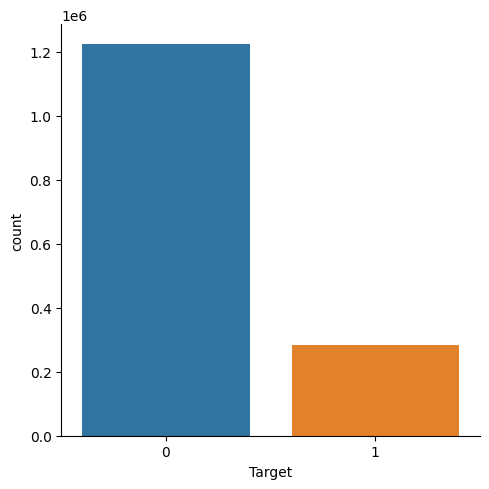

In [290]:
# Explore Target distribution
sns.catplot(x="Target", kind="count", data=train)

There is a large imbalance of data, far more clients are inactive than active.

Let's examine the nulls.

### 2. Understand The Dataset


### 2.1. Nulls

In [291]:
# Check for missing values
print('missing values:', train.isnull().sum())

missing values: ID                        0
region               594091
tenure                    0
Amount               529514
refill_frequency     529514
revenue              508121
arpu_segment         508121
frequency            508121
data_volume          741806
on_net               550642
Procuct_1            626563
Procuct_2            903050
zone1               1388848
zone2               1412329
mrg                       0
regularity                0
top_pack             631823
freq_top_pack        631823
Target                    0
dtype: int64


Majority of zone1 and zone2 do not have many values. This could be an issue, so they will need to be dropped along with other columns that are missing more than 50% of their values (753900 or more). Let's investigate the relationship between the missing values.

In [292]:
import missingno as msno

The msno.matrix nullity matrix is a data-dense display which will allow us to quickly visually pick out patterns in data completion

<Axes: >

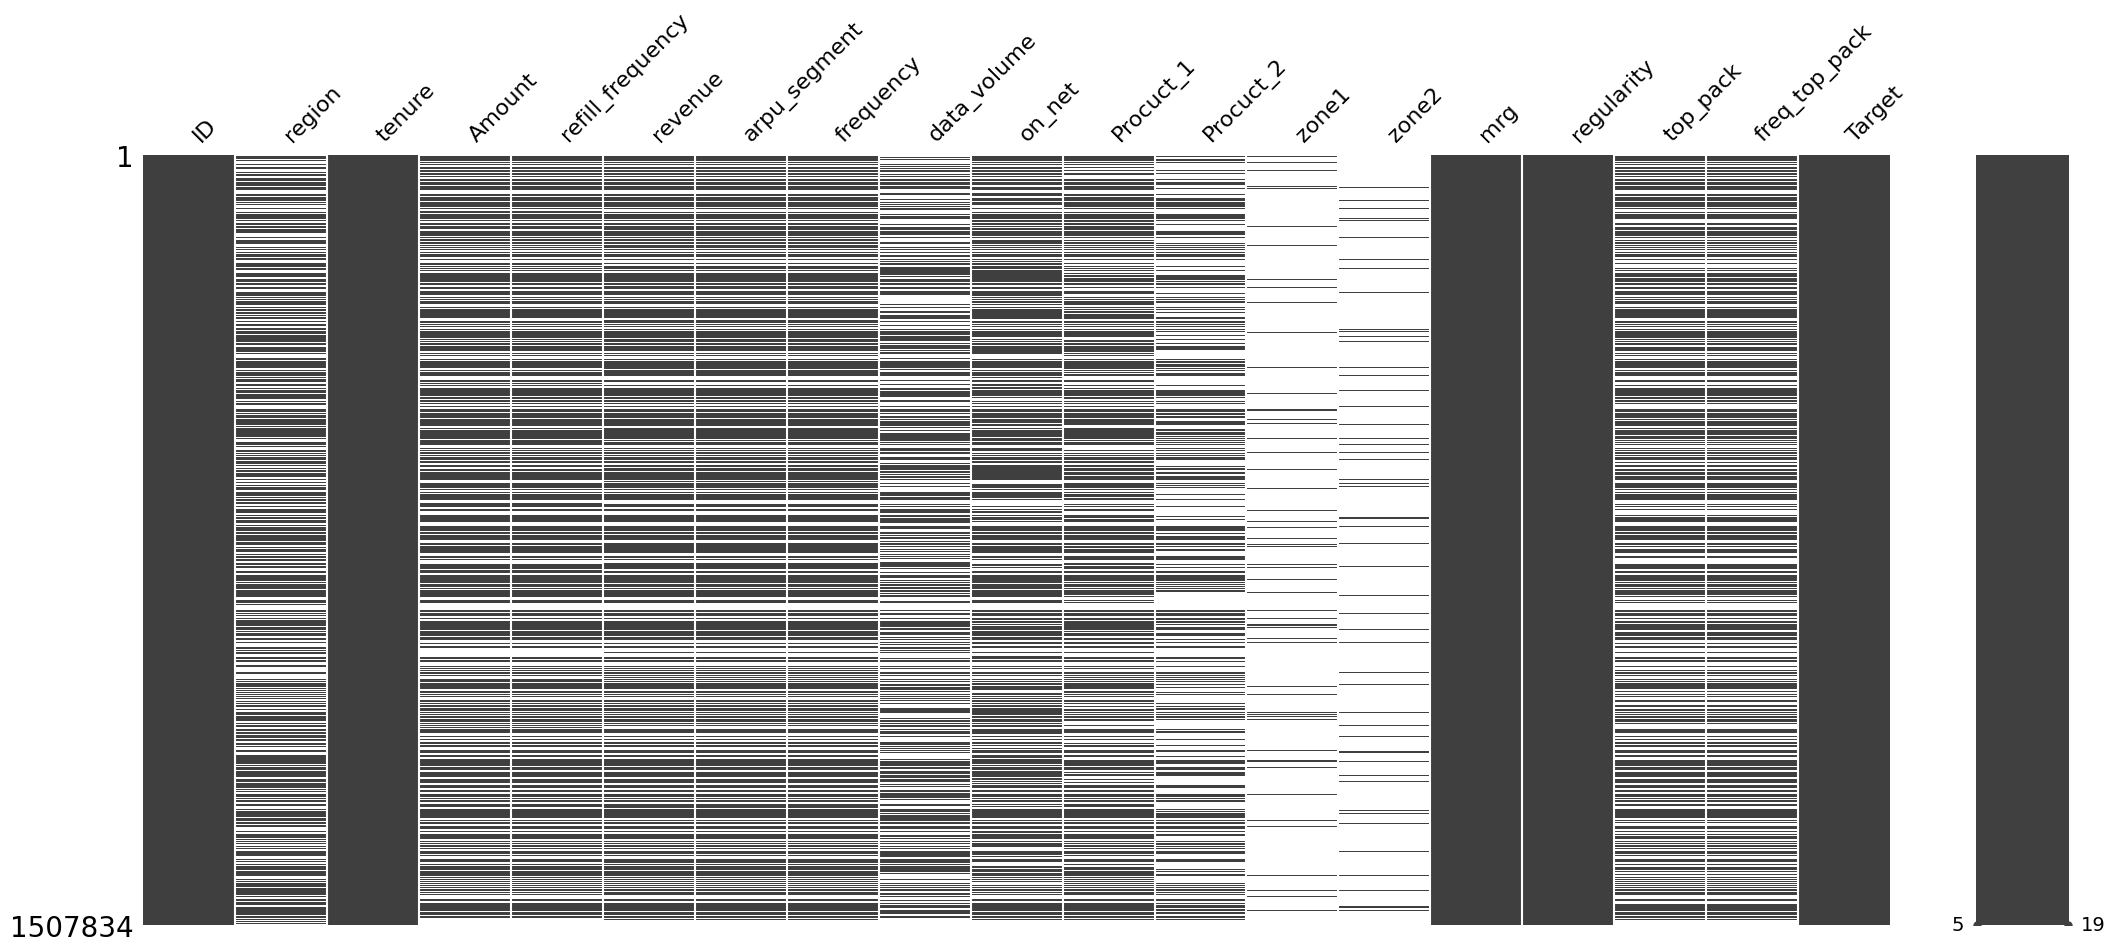

In [293]:
msno.matrix(train)

Clearly the values are not missing at random.


*   Region, Amount, refill_frequency, revenue, arpu_segment, frequency, on_net, top_pack, and freq_top_pack are all correlated.

Let us sort the matrix to see if we can delete the columns that are sparsely populated.



<Axes: >

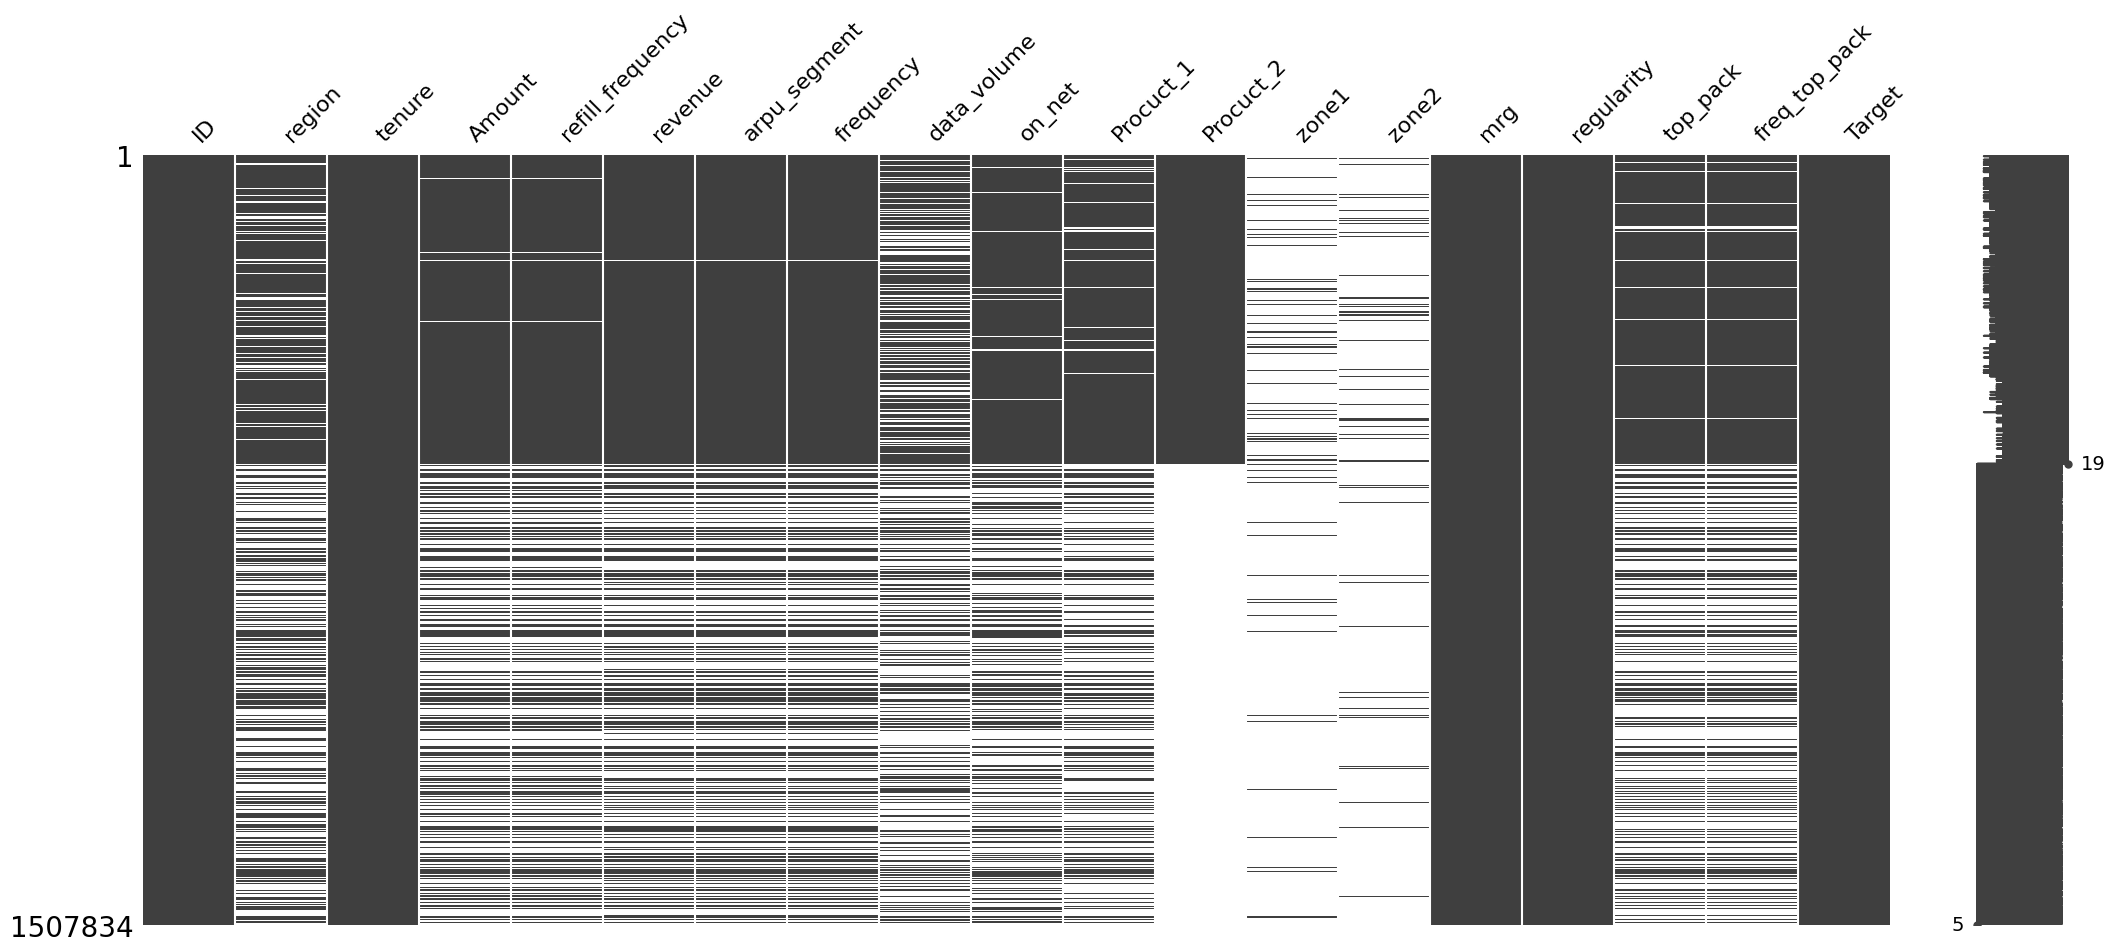

In [294]:
# Sorted by Procuct_2
sorted = train.sort_values('Procuct_2')
msno.matrix(sorted)

Procuct_2 cannot be safely deleted as it correlates with the other columns. zone1 and zone2 can be deleted though.

In [295]:
# Deleting the zone columns
train_nonull = train.drop(['zone1','zone2'], axis=1)
test_nonull = test.drop(['zone1','zone2'], axis=1)

In [296]:
# Drop all the nulls


In [297]:
# Checking the null columns are gone
train_nonull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507834 entries, 0 to 1507833
Data columns (total 17 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   ID                1507834 non-null  object 
 1   region            913743 non-null   object 
 2   tenure            1507834 non-null  object 
 3   Amount            978320 non-null   float64
 4   refill_frequency  978320 non-null   float64
 5   revenue           999713 non-null   float64
 6   arpu_segment      999713 non-null   float64
 7   frequency         999713 non-null   float64
 8   data_volume       766028 non-null   float64
 9   on_net            957192 non-null   float64
 10  Procuct_1         881271 non-null   float64
 11  Procuct_2         604784 non-null   float64
 12  mrg               1507834 non-null  object 
 13  regularity        1507834 non-null  int64  
 14  top_pack          876011 non-null   object 
 15  freq_top_pack     876011 non-null   float64
 16  

For the rest of the nulls, we will impute them using the MICE technique so as not to lose valuable data. This will happen once the data is clean and ready to use.

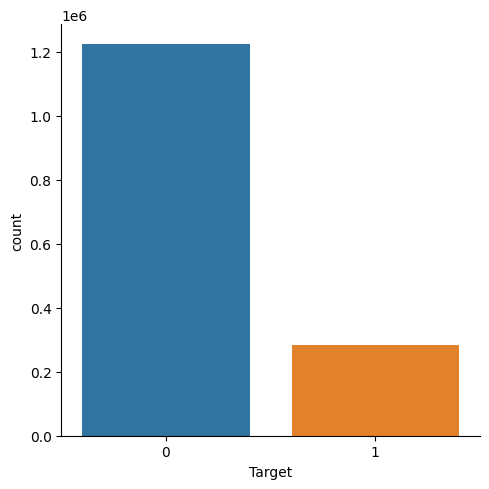

In [298]:
# Explore Target distribution
sns.catplot(x="Target", kind="count", data=train_nonull)

In [299]:
# from sklearn.impute import KNNImputer
# train_knn = train_nonull.copy(deep=True)

# knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")

In [300]:
#train_knn['region'] = knn_imputer.fit_transform(train_knn[['region']])

In [301]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# train_mice = train_nonull.copy(deep=True)

# mice_imputer = IterativeImputer()

In [302]:
# train_mice['region'] = mice_imputer.fit_transform(train_mice[['region']])
# train_mice['Amount'] = mice_imputer.fit_transform(train_mice[['Amount']])
# train_mice['refill_frequency'] = mice_imputer.fit_transform(train_mice[['refill_frequency']])
# train_mice['revenue'] = mice_imputer.fit_transform(train_mice[['revenue']])
# train_mice['arpu_segment'] = mice_imputer.fit_transform(train_mice[['arpu_segment']])
# train_mice['frequency'] = mice_imputer.fit_transform(train_mice[['frequency']])
# train_mice['data_volume'] = mice_imputer.fit_transform(train_mice[['data_volume']])
# train_mice['on_net'] = mice_imputer.fit_transform(train_mice[['on_net']])
# train_mice['Procuct_1'] = mice_imputer.fit_transform(train_mice[['Procuct_1']])
# train_mice['Procuct_2'] = mice_imputer.fit_transform(train_mice[['Procuct_2']])
# train_mice['top_pack'] = mice_imputer.fit_transform(train_mice[['top_pack']])
# train_mice['freq_top_pack'] = mice_imputer.fit_transform(train_mice[['freq_top_pack']])

### 2.2. Data Types

In [303]:
#Show the datatypes
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507834 entries, 0 to 1507833
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   ID                1507834 non-null  object 
 1   region            913743 non-null   object 
 2   tenure            1507834 non-null  object 
 3   Amount            978320 non-null   float64
 4   refill_frequency  978320 non-null   float64
 5   revenue           999713 non-null   float64
 6   arpu_segment      999713 non-null   float64
 7   frequency         999713 non-null   float64
 8   data_volume       766028 non-null   float64
 9   on_net            957192 non-null   float64
 10  Procuct_1         881271 non-null   float64
 11  Procuct_2         604784 non-null   float64
 12  zone1             118986 non-null   float64
 13  zone2             95505 non-null    float64
 14  mrg               1507834 non-null  object 
 15  regularity        1507834 non-null  int64  
 16  

We can now see that there are 5 objects, 2 ints, and the rest are floats. The ones that are not floats will need to be converted.

### 2.3. Outliers

Let's check the data for outliers.

<Axes: >

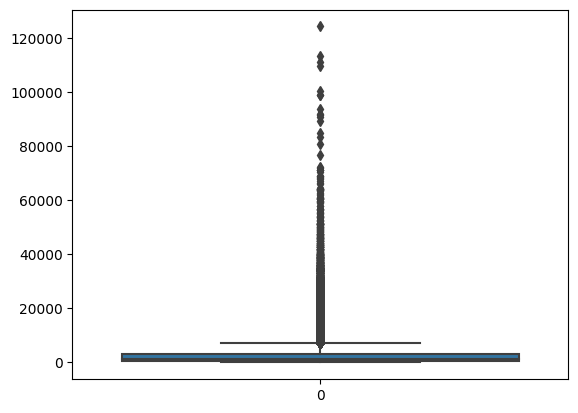

In [304]:
# Checking for outliers
sns.boxplot(data=train["Amount"])

<Axes: >

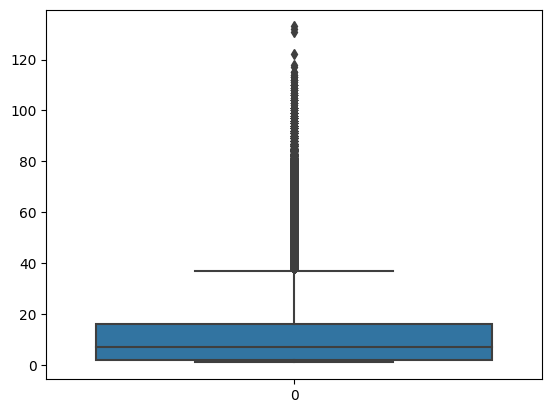

In [305]:
# Checking for outliers
sns.boxplot(data=train["refill_frequency"])

<Axes: >

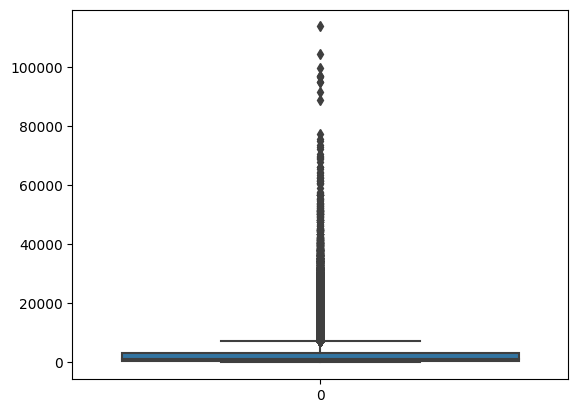

In [306]:
# Checking for outliers
sns.boxplot(data=train["revenue"])

<Axes: >

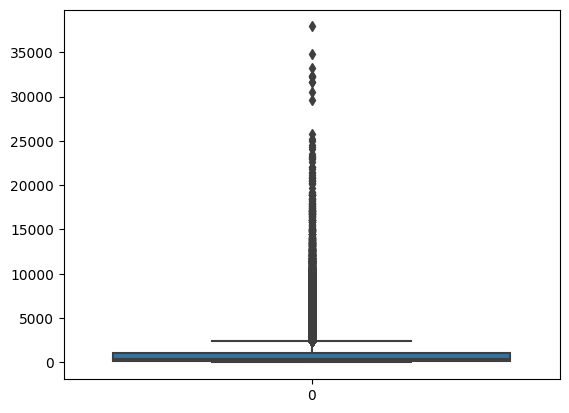

In [307]:
# Checking for outliers
sns.boxplot(data=train["arpu_segment"])

<Axes: >

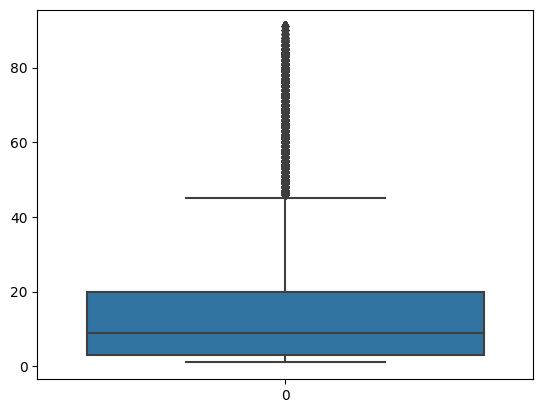

In [308]:
# Checking for outliers
sns.boxplot(data=train["frequency"])

<Axes: >

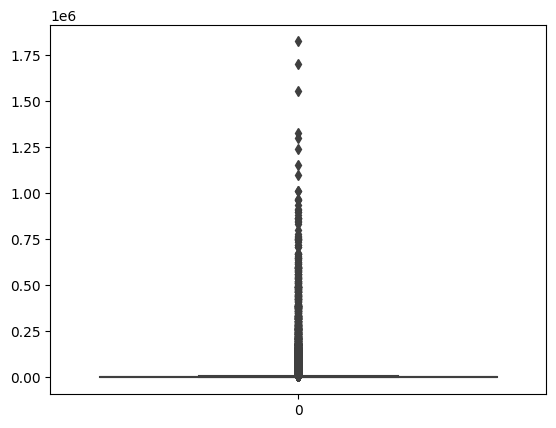

In [309]:
# Checking for outliers
sns.boxplot(data=train["data_volume"])

<Axes: >

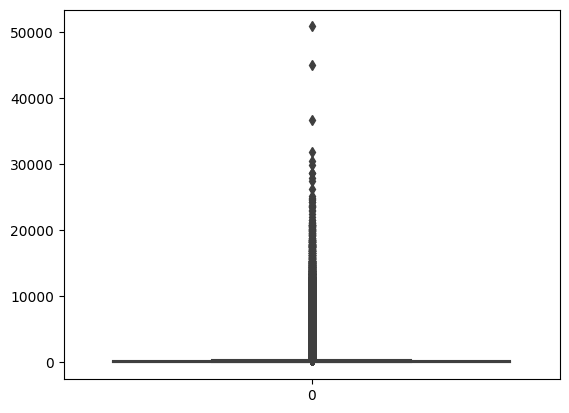

In [310]:
# Checking for outliers
sns.boxplot(data=train["on_net"])

<Axes: >

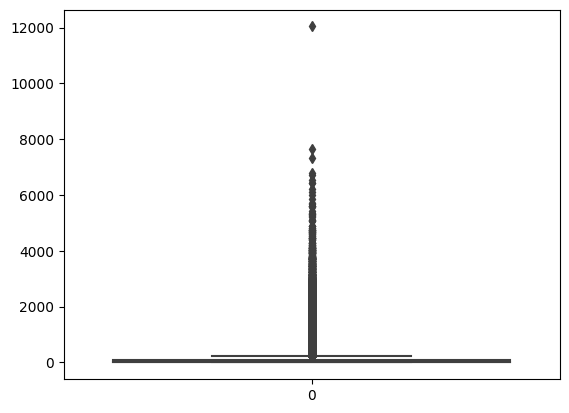

In [311]:
# Checking for outliers
sns.boxplot(data=train["Procuct_1"])

<Axes: >

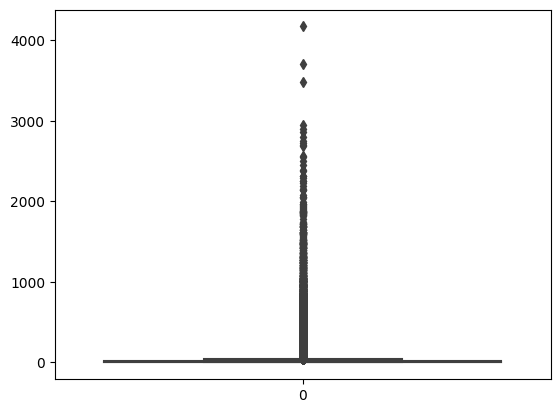

In [312]:
# Checking for outliers
sns.boxplot(data=train["Procuct_2"])

### 2.4. Correlation

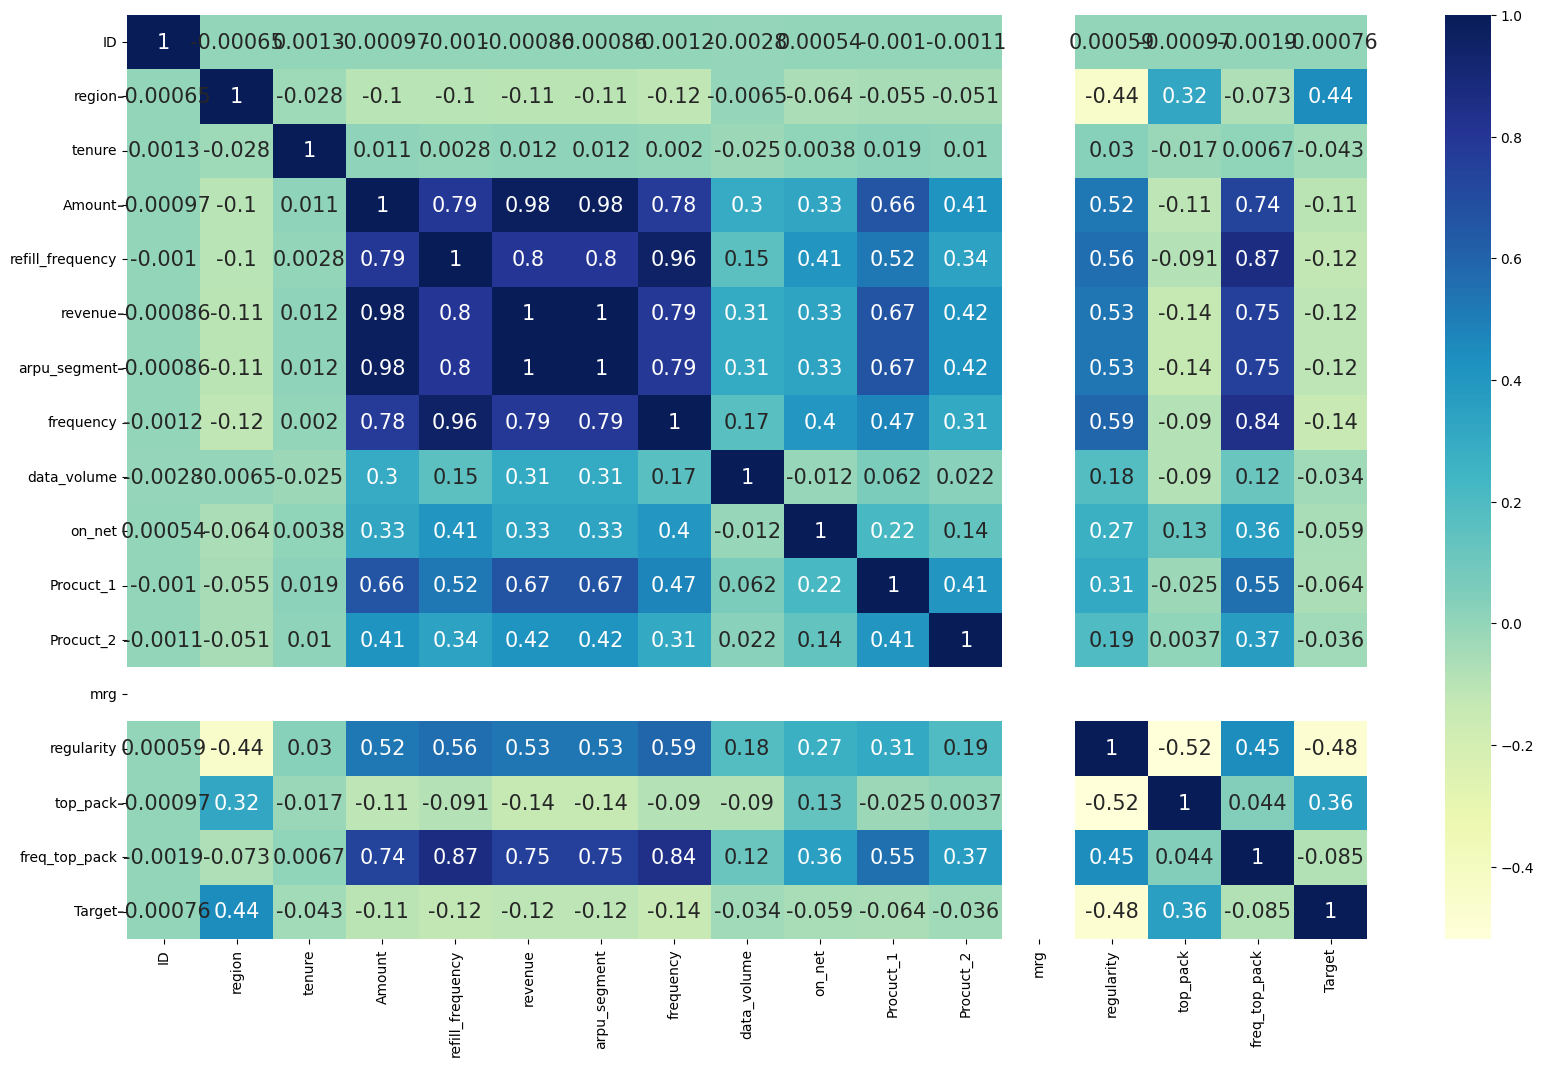

In [313]:
#import preprocessing module
from sklearn.preprocessing import LabelEncoder

# create new df for heatmap
corr_train = train_nonull

# Convert target label to numerical Data
le = LabelEncoder()
corr_train['ID'] = le.fit_transform(corr_train['ID'])
corr_train['region'] = le.fit_transform(corr_train['region'])
corr_train['tenure'] = le.fit_transform(corr_train['tenure'])
corr_train['mrg'] = le.fit_transform(corr_train['mrg'])
corr_train['top_pack'] = le.fit_transform(corr_train['top_pack'])
plt.figure(figsize=(20,12))

# plotting correlation heatmap
dataplot = sns.heatmap(corr_train.corr(), cmap="YlGnBu", annot=True,annot_kws={'size': 15})

# displaying heatmap
plt.show()

There are high levels of correlation between Amount, refill_frequency, revenue, arpu_segment, and frequency. This could could issues with multicollinearity later.

### 3. Data Preparation

### 3.1. Preprocessing


We have created a simple preprocessing function to:

*   Handle conversion of data types
*   Convert categorical features to numerical features by using One-hot Encoder and Label Encoder
*   Drop uniqueid variable
*   Perform feature scaling

The processing function will be used for both train and test independent variables.

In [314]:
#import preprocessing module
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer



# function to preprocess our data from train models
def preprocessing_data(data):

    # Convert the following numerical labels from integer to float
    float_array = data[["regularity"]].values.astype(float)

    # # categorical features to be converted to One Hot Encoding
    # categ = ["region",
    #          "tenure",
    #          "mrg",
    #          "top_pack",
    #          ]

    # # One Hot Encoding conversion
    # data = pd.get_dummies(data, prefix_sep="_", columns=categ)

    # Label Encoder conversion
    data["region"] = le.fit_transform(data["region"])
    data["tenure"] = le.fit_transform(data["tenure"])
    data["top_pack"] = le.fit_transform(data["top_pack"])


    # drop uniquid column
    data = data.drop(["ID", "mrg"], axis=1)

    # # impute missing values
    # train_mice = data.copy()

    # mice_imputer = IterativeImputer()

    # train_mice['region'] = mice_imputer.fit_transform(train_mice[['region']])
    # train_mice['Amount'] = mice_imputer.fit_transform(train_mice[['Amount']])
    # train_mice['refill_frequency'] = mice_imputer.fit_transform(train_mice[['refill_frequency']])
    # train_mice['revenue'] = mice_imputer.fit_transform(train_mice[['revenue']])
    # train_mice['arpu_segment'] = mice_imputer.fit_transform(train_mice[['arpu_segment']])
    # train_mice['frequency'] = mice_imputer.fit_transform(train_mice[['frequency']])
    # train_mice['data_volume'] = mice_imputer.fit_transform(train_mice[['data_volume']])
    # train_mice['on_net'] = mice_imputer.fit_transform(train_mice[['on_net']])
    # train_mice['Procuct_1'] = mice_imputer.fit_transform(train_mice[['Procuct_1']])
    # train_mice['Procuct_2'] = mice_imputer.fit_transform(train_mice[['Procuct_2']])
    # train_mice['top_pack'] = mice_imputer.fit_transform(train_mice[['top_pack']])
    # train_mice['freq_top_pack'] = mice_imputer.fit_transform(train_mice[['freq_top_pack']])

    return data

In [315]:
# preprocess the train data
processed_train = preprocessing_data(train_nonull)
processed_test = preprocessing_data(test_nonull)

### Upsampling


In [316]:
processed_train['Target'].groupby(processed_train['Target']).count()

Target
0    1225319
1     282515
Name: Target, dtype: int64

In [317]:
# from sklearn.utils import resample
# maxcount = 1225319
# train_resampled = processed_train[0:0]
# for grp in processed_train['Target'].unique():
#     GrpDF = processed_train[train['Target'] == grp]
#     resampled = resample(GrpDF, replace=True, n_samples=int(maxcount), random_state=123)
#     train_resampled = train_resampled.append(resampled)

In [335]:
retain = processed_train[processed_train["Target"] == 1]
leave  = processed_train[processed_train["Target"] == 0]
print(retain.shape)
print(leave.shape)

(282515, 15)
(1225319, 15)


In [336]:
from sklearn.utils import resample
leave_downsample = resample(leave,
             replace=True,
             n_samples=len(retain),
             random_state=42)

In [337]:
data_downsampled = pd.concat([leave_downsample, retain])

### 3.2. Split X and y

In [338]:

#Separate training features from target
X_train = data_downsampled.drop(['Target'], axis=1)
y_train = data_downsampled['Target'].values.astype(float)

print(y_train)

[0. 0. 0. ... 1. 1. 1.]


Sanity check

In [339]:
# the first train row
print(X_train[:1])

        region  tenure  Amount  refill_frequency  revenue  arpu_segment  \
149813       0       7     NaN               NaN      NaN           NaN   

        frequency  data_volume  on_net  Procuct_1  Procuct_2  regularity  \
149813        NaN          NaN     1.0        NaN        NaN           3   

        top_pack  freq_top_pack  
149813       130            NaN  


In [320]:
# shape of the processed train set
print(X_train.shape)

(1507834, 14)


### 3.3. Scaling

In [340]:
# scale our data into range of 0 and 1
def scaling(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scalednp = scaler.fit_transform(df)

    return scalednp

In [341]:
X_scaled = scaling(X_train)
test_scaled = scaling(processed_test)

### 4. Models and Experimentation

### 4.1. Train-Test Split

In [342]:
import sklearn.model_selection

# Split train_data
from sklearn.model_selection import train_test_split

X_Train, X_Val, y_Train, y_val = train_test_split(X_scaled, y_train, stratify = y_train,
                                                  test_size = 0.1, random_state=42)

### 4.2. Base Model

In [343]:
#import classifier algorithm here
from xgboost import XGBClassifier

# create models
xg_model = XGBClassifier()

#fitting the models
xg_model.fit(X_Train,y_Train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [344]:
# import evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score

# evaluate the model
xg_y_model = xg_model.predict(X_Val)

# Get error rate
print("Error rate of XGB classifier: ", 1 - accuracy_score(y_val, xg_y_model))

Error rate of XGB classifier:  0.13298408934038897


In [345]:
from sklearn.metrics import f1_score
y_pred = xg_model.predict(X_Val)
f1_score(y_val, y_pred, average=None)

array([0.8596406 , 0.87365483])

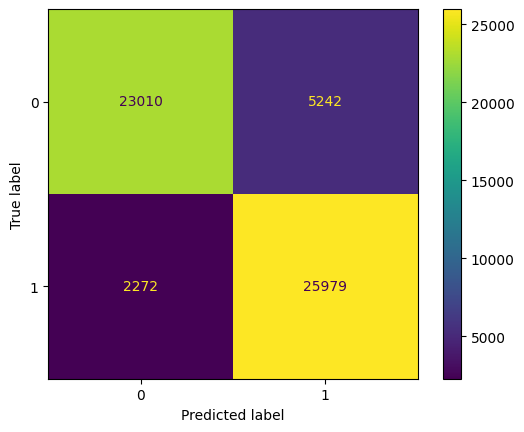

In [346]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get confusion matrix for Gradient Boosting Classifier
#plot_confusion_matrix(xg_model,X_Val, y_val,normalize='true')
cm = confusion_matrix(y_val, xg_y_model, labels=xg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xg_model.classes_)
disp.plot()
plt.show()

In [328]:
# # Import GridSearchCV
# from sklearn.model_selection import GridSearchCV

# # Optimize model parameters
# # I run this code in google colab to make the execution much faster and use the best params in the next code
# param_grid = {'min_child_weighth': [1, 5, 10],
#         'gamma': [0.5, 1],
#         'subsample': [0.6, 0.8, 1.0],
#         'max_depth': [3, 5]
#         }
# my_xgb_model = GridSearchCV(xg_model, param_grid,n_jobs=-1,verbose=2,cv=5)
# my_xgb_model.fit(X_Train, y_Train)
# print(my_xgb_model.best_params_)

In [347]:
# fit by setting best parameters and Evaluate model
xgb_model = XGBClassifier(min_child_weight=1, gamma=0.5, subsample=1, max_depth=5)

xgb_model.fit(X_Train, y_Train)
y_pred = xgb_model.predict(X_Val)
f1_score(y_val, y_pred, average=None)

array([0.85959275, 0.8736297 ])

### 5. Submission

In [348]:
processed_train.shape

(1507834, 15)

In [349]:
# Get the predicted result for the test Data
test.Target = xgb_model.predict(processed_test)

In [350]:
# Create submission DataFrame
submission = pd.DataFrame({"ID": test["ID"],
                           "Target": test.Target})

In [351]:
#show the five sample
submission.sample(5)

,ID,Target
289014,ID_EQNQP3FGDJI0,0
100866,ID_YQHI06GTA210,0
171474,ID_XFCFD71CRDM1,0
294428,ID_ZXNYAFZHAF1E,0
91903,ID_8F4VIHYIRMYN,0


In [352]:
# Create submission csv file csv file
submission.to_csv('no_impute_downsample.csv', index = False)
files.download('no_impute_downsample.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>